In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import temp_crt

plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.constrained_layout.use'] = True


# py.offline.init_notebook_mode(connected=True)

In [2]:
# parse the letter 'D' (mocap data)
traj = temp_crt.parse_trajectory("D")
strokes = traj[0]
#print(strokes)
t = strokes[0]
x = strokes[1]
y = strokes[2]
stroke1 = strokes[:, 0:31]  # Y = -0.34639319
np.savetxt("stroke1.csv", np.transpose(stroke1), delimiter=",")
stroke2 = strokes[:, 31:57] # X = 0.74592703
np.savetxt("stroke2.csv", np.transpose(stroke2), delimiter=",")
stroke3 = strokes[:, 57::] # to end
np.savetxt("stroke3.csv", np.transpose(stroke3), delimiter=",")
#print(np.transpose(stroke1))
#print(" ")
#print(np.transpose(stroke2))
#print(" ")
#print(np.transpose(stroke3))

stroke1_nt = np.array([x[0:31],y[0:31]])
t_nt = t[0:31]
#print(stroke1_nt)
velocity = np.sqrt(np.sum((np.gradient(strokes, axis=1)/0.008333)**2,
                                  axis=0))
#print(velocity)

# Import csv file (gtsam result)
columns = ["time", "x", "y"]
gt1_1 = pd.read_csv("../build/cpp/SLM/tests/gtsam1_stroke1.csv", usecols=columns)
gt1_t1 = gt1_1.time.tolist()
gt1_x1 = gt1_1.x.tolist()
gt1_y1 = gt1_1.y.tolist()
gt1_v1 = np.sqrt(np.sum((np.gradient(np.array([gt1_x1,gt1_y1]), axis=1)/(1/120/2))**2,
                                  axis=0))
gt2_1 = pd.read_csv("../build/cpp/SLM/tests/gtsam2_stroke1.csv", usecols=columns)
gt2_t1 = gt2_1.time.tolist()
gt2_x1 = gt2_1.x.tolist()
gt2_y1 = gt2_1.y.tolist()
gt2_v1 = np.sqrt(np.sum((np.gradient(np.array([gt2_x1,gt2_y1]), axis=1)/(1/120/2))**2,
                                  axis=0))
gt2_2 = pd.read_csv("../build/cpp/SLM/tests/gtsam2_stroke2.csv", usecols=columns)
gt2_t2 = gt2_2.time.tolist()
gt2_x2 = gt2_2.x.tolist()
gt2_y2 = gt2_2.y.tolist()
gt2_v2 = np.sqrt(np.sum((np.gradient(np.array([gt2_x2,gt2_y2]), axis=1)/(1/120/2))**2,
                                  axis=0))
gt3_1 = pd.read_csv("../build/cpp/SLM/tests/gtsam3_stroke1.csv", usecols=columns)
gt3_t1 = gt3_1.time.tolist()
gt3_x1 = gt3_1.x.tolist()
gt3_y1 = gt3_1.y.tolist()
gt3_v1 = np.sqrt(np.sum((np.gradient(np.array([gt3_x1,gt3_y1]), axis=1)/(1/120/2))**2,
                                  axis=0))
gt3_2 = pd.read_csv("../build/cpp/SLM/tests/gtsam3_stroke2.csv", usecols=columns)
gt3_t2 = gt3_2.time.tolist()
gt3_x2 = gt3_2.x.tolist()
gt3_y2 = gt3_2.y.tolist()
gt3_v2 = np.sqrt(np.sum((np.gradient(np.array([gt3_x2,gt3_y2]), axis=1)/(1/120/2))**2,
                                  axis=0))
gt3_3 = pd.read_csv("../build/cpp/SLM/tests/gtsam3_stroke3.csv", usecols=columns)
gt3_t3 = gt3_3.time.tolist()
gt3_x3 = gt3_3.x.tolist()
gt3_y3 = gt3_3.y.tolist()
gt3_v3 = np.sqrt(np.sum((np.gradient(np.array([gt3_x3,gt3_y3]), axis=1)/(1/120/2))**2,
                                  axis=0))

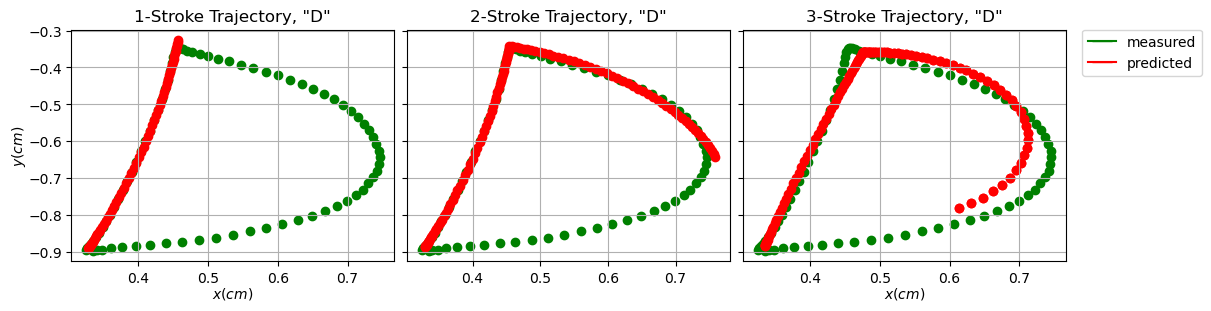

In [3]:
# Plotting
blk_ln = mlines.Line2D([], [], color='black', marker='_',
                       markersize=15, label='measured')
green_pt = mlines.Line2D([], [], color='green', marker='_',
                         markersize=15, label='measured')
red_pt = mlines.Line2D([], [], color='red', marker='_',
                       markersize=15, label='predicted')
yellow_ln = mlines.Line2D([], [], color='yellow', marker='_',
                          markersize=15, label='error')

fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
axs[0].set_title('1-Stroke Trajectory, "D"')
axs[0].grid(visible=1)
axs[0].scatter(x, y, c='g')
axs[0].scatter(gt1_x1, gt1_y1, c='r')
axs[0].set_xlabel('$x (cm)$',labelpad=0)
axs[0].set_ylabel('$y (cm)$',labelpad=0)

axs[1].set_title('2-Stroke Trajectory, "D"')
axs[1].grid(visible=1)
axs[1].scatter(x, y, c='g')
axs[1].scatter(gt2_x1, gt2_y1, c='r')
axs[1].scatter(gt2_x2, gt2_y2, c='r')
plt.xlabel('$x (cm)$',labelpad=0)

axs[2].set_title('3-Stroke Trajectory, "D"')
axs[2].grid(visible=1)
axs[2].scatter(x, y, c='g')
axs[2].scatter(gt3_x1, gt3_y1, c='r')
axs[2].scatter(gt3_x2, gt3_y2, c='r')
axs[2].scatter(gt3_x2, gt3_y2, c='r')
plt.xlabel('$x (cm)$',labelpad=0)

plt.legend(handles=[green_pt, red_pt],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

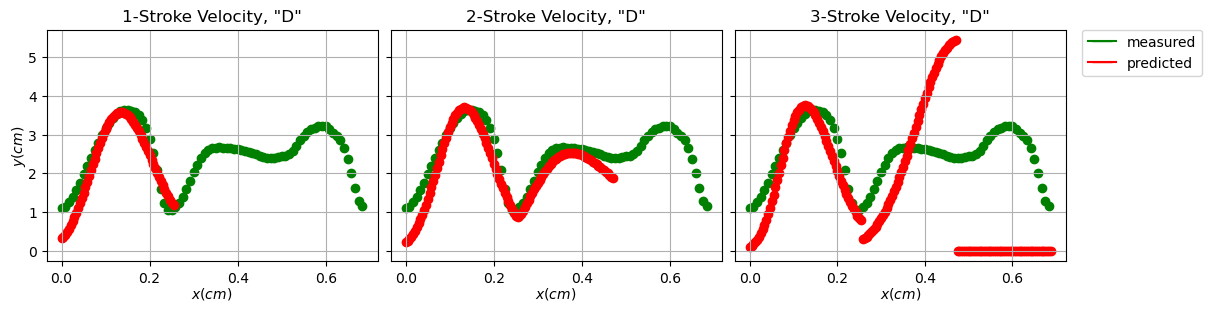

In [4]:
fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
axs[0].set_title('1-Stroke Velocity, "D"')
axs[0].grid(visible=1)
axs[0].scatter(t, velocity, c='g')
axs[0].scatter(gt1_t1, gt1_v1, c='r')
axs[0].set_xlabel('$x (cm)$',labelpad=0)
axs[0].set_ylabel('$y (cm)$',labelpad=0)

axs[1].set_title('2-Stroke Velocity, "D"')
axs[1].grid(visible=1)
axs[1].scatter(t, velocity, c='g')
axs[1].scatter(gt2_t1, gt2_v1, c='r')
axs[1].scatter(gt2_t2, gt2_v2, c='r')
axs[1].set_xlabel('$x (cm)$',labelpad=0)

axs[2].set_title('3-Stroke Velocity, "D"')
axs[2].grid(visible=1)
axs[2].scatter(t, velocity, c='g')
axs[2].scatter(gt3_t1, gt3_v1, c='r')
axs[2].scatter(gt3_t2, gt3_v2, c='r')
axs[2].scatter(gt3_t3, gt3_v3, c='r')
axs[2].set_xlabel('$x (cm)$',labelpad=0)

plt.legend(handles=[green_pt, red_pt],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# fig, ax = plt.subplots()
# plt.title('Speed Profile')
# plt.grid(visible=1)
# # for i, s in enumerate(strokes):
# #     plt.fill_between(t, 0, s, where=s > 0, facecolor='grey', alpha=0.5)
# #plt.plot(t_nt, velocity, 'g')
# plt.plot(t, velocity, 'g')
# plt.plot(t_gt1, v_gt1, 'r')
# plt.plot(t_gt2, v_gt2, 'r')
# #plt.plot(t_gt3, v_gt3, 'b')
# plt.xlabel('$t$', labelpad=0)
# plt.ylabel('speed', labelpad=0)
# ax.set_box_aspect(1)
# plt.legend(handles=[green_pt, red_pt],
#            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [5]:
# plt.scatter(px, py, c='g')
# plt.scatter(Xx, Xy, c='r')
# for i in range(len(px)):
#     lineXdata = (px[i], px[i])  # same X
#     lineYdata = (py[i], Xy[i])  # different Y
#     plt.plot(lineXdata, lineYdata, c='y')
# plt.xlabel('$x$', labelpad=0)
# plt.ylabel('y', labelpad=0)
# ax.set_box_aspect(1)
# plt.legend(handles=[blk_ln, green_pt, red_pt],
#            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# fig, axs = plt.subplots(2, sharex=True)
# fig.suptitle('X and Y vs Time')
# axs[0].grid()
# axs[0].scatter(tm, px, c='g')
# axs[0].scatter(tm, Xx, c='r')
# for i in range(len(px)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (px[i], Xx[i])  # different Y
#     axs[0].plot(lineXdata, lineYdata, c='y')
# axs[0].set(xlabel='$t$', ylabel='x')
# axs[1].grid()
# axs[1].scatter(tm, py, c='g')
# axs[1].scatter(tm, Xy, c='r')
# for i in range(len(py)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (py[i], Xy[i])  # different Y
#     axs[1].plot(lineXdata, lineYdata, c='y')
# axs[1].set(xlabel='$t$', ylabel='y')
# plt.legend(handles=[green_pt, red_pt, yellow_ln],
#            loc='right')

# fig, ax = plt.subplots()
# plt.title('Speed Profile')
# plt.grid(visible=1)
# for i, s in enumerate(strokes):
#     plt.fill_between(t, 0, s, where=s > 0, facecolor='grey', alpha=0.5)
# plt.plot(t, velocity, 'k')
# plt.scatter(tm, v, c='g')
# plt.scatter(tm, V, c='r')
# for i in range(len(px)):
#     lineXdata = (tm[i], tm[i])  # same X
#     lineYdata = (v[i], V[i])  # different Y
#     plt.plot(lineXdata, lineYdata, c='y')
# plt.xlabel('$t$', labelpad=0)
# plt.ylabel('speed', labelpad=0)
# ax.set_box_aspect(1)
# plt.legend(handles=[blk_ln, green_pt, red_pt, yellow_ln],
#            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)